# Neural Networks

Environment: R 3.6.1 and Jupyter notebook

Libraries used:
* dplyr
* ggplot2

## Introduction

In this notebook, the 3-layer neural network and perceptron will be implemented. After the algorithms are implemented, the best model for each model will be visualized to observe the difference of these two models. 

## Import libraries

In [1]:
library(dplyr)
library(ggplot2)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [9]:
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

# reading the data
read.data <- function(file.name, scaling=FALSE) {
  data <- read.csv(file=file.name,head=TRUE,sep=",")
  data <- data[complete.cases(data),] # removes rows with NA values
  D <- ncol(data)
  x = data[,-D]
  y = data[,D]
  if (isTRUE(scaling)) {
    x = scale(x)
    y = scale(y)
  }
  return (list('x' = x, 'y' = y))
}

error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}

####################### PERCEPTRON #######################
## prediction
perceptron.predict <- function(Phi, W){
  return(ifelse(Phi%*%W>=0, +1, -1))
}
## is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
  return((W%*%Phi)*T1<0)
}

## Perceptron Build function
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
  if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
  }
  if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
  }
  
  N1 <- nrow(X1)
  Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0

  W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
  W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
  error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
  error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
  tau <- 1 # iteration counter 
  terminate <- FALSE # termination status
  
  while(!terminate){
    # resuffling train data and associated labels:
    indx <- sample(1:N1, replace = FALSE)
    Phi <- Phi[indx,]
    T1 <- T1[indx]
    
    for (i in 1:N1){
      if (tau >= tau.max) {break}
      # look for missclassified samples
      if (is.a.miss(Phi[i,], W[tau,], T1[i])){
        tau <- tau +1                                 # update tau counter
        W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
        error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
        eta = eta * 0.99                                 # decrease eta
      } 
    }
    
    # recalculate termination conditions
    terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    
  }
  if (plotting){
    plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
  }
  W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
  return(W[nrow(W),])         # return the last wight vector
}

####################### NEURAL NET ####################### 
## the activation function (tanh here)
h <- function(z) {
  return ((exp(z)-exp(-z))/(exp(z)+exp(-z)))
}
## the derivitive of the activation function (tanh here)
h.d <- function(z) {
  return (1-(h(z))^2)
}
## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}
## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}
## feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}
## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}
## NN build function
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01){
  # initialization
  if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
  D <- nrow(X1)
  if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
  N <- ncol(X1)

  W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
  b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
  W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
  b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

  for (epoch in 1:epoch.max){   
    for (i in 1:N){
      ## Feedforward:
      list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
      ## Backpropagation:
      list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
      ## update weight vectors and matrices
      W1 <- W1 - eta * (d2 %*% t(a1) + lambda * W1)
      b1 <- b1 - eta * d2
      W2 <- W2 - eta * (d3 %*% t(a2) + lambda * W2)
      b2 <- b2 - eta * d3
    }
    ## record the errors
    if (plotting){error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)}
  }
  if (plotting) plot(error.rec, xlab = 'epoch', ylab = 'error', main = 'Neural Net')
  return(list(W1, W2, b1, b2))
}

## Read data

In [11]:
# Read the datasets
set.seed(5201)          # set random seed
list[X1,T1] <- read.data('train7.csv') # read training data
T1[T1==0] <- -1         # convert 0 labels to -1 
list[X2,T2] <- read.data('test7.csv') # read test data
T2[T2==0] <- -1         # convert 0 labels to -1 

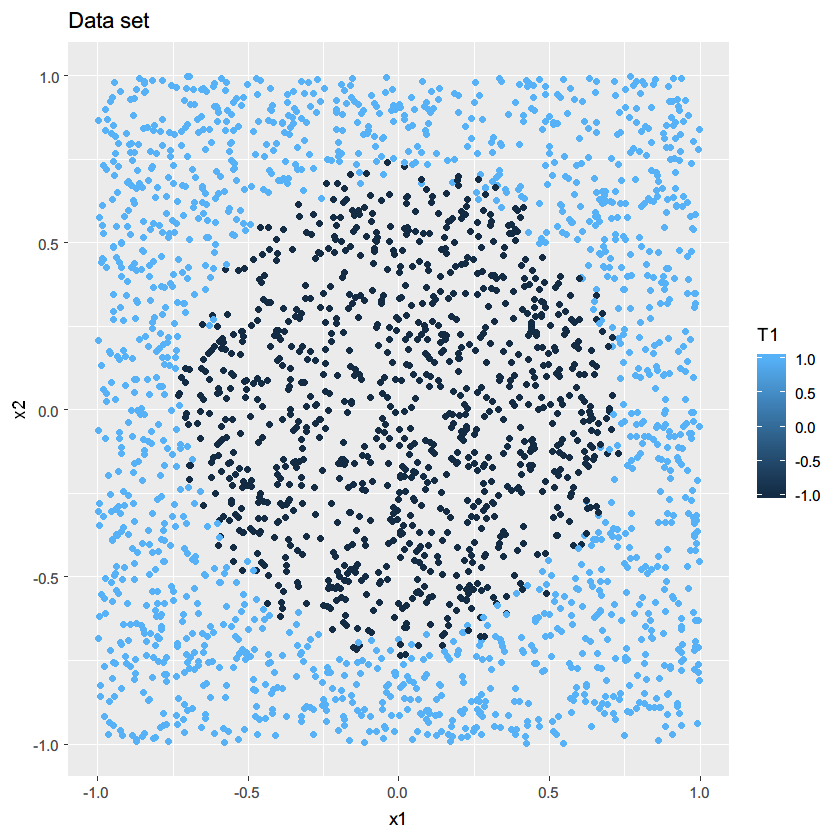

In [12]:
# Plot training dataset
ggplot(data=cbind(X1, T1), aes(x=x1, y=x2, color=T1)) +
    geom_point() + ggtitle ('Data set')

From the output, these 2 classes of the data is not linearly separable.
## Perceptron

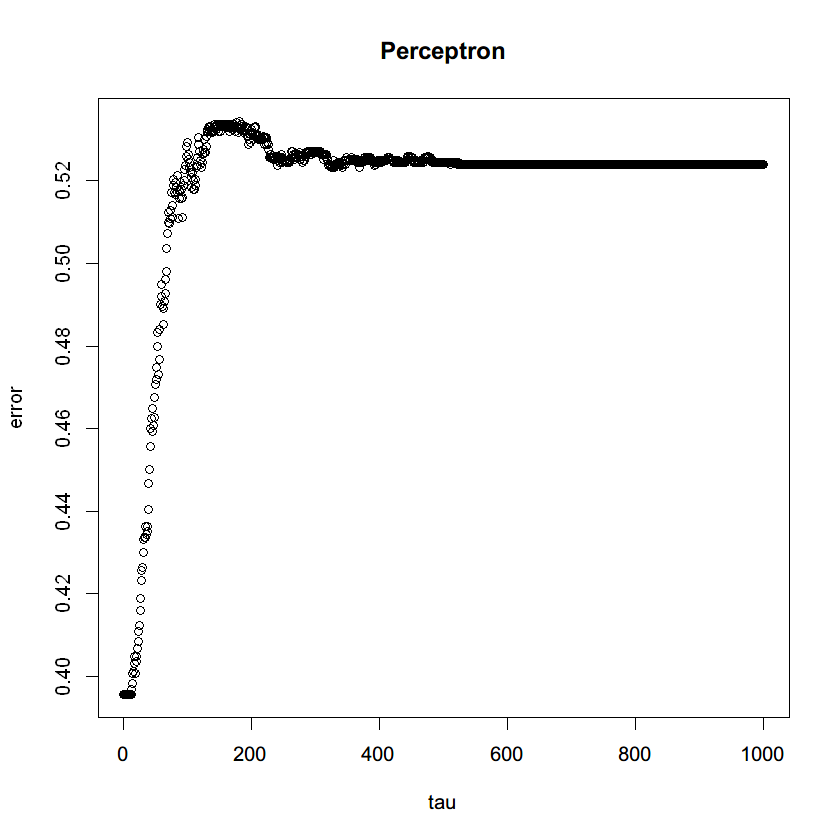

In [13]:
# Build a perceptron and plot its train error curve
set.seed(0)
# perceptron model with learning rate = 0.01
W001 <- perceptron.build(X1, T1, tau.max = 1000, plotting = TRUE, eta = 0.01) # Run this a few times until you are happy with the result

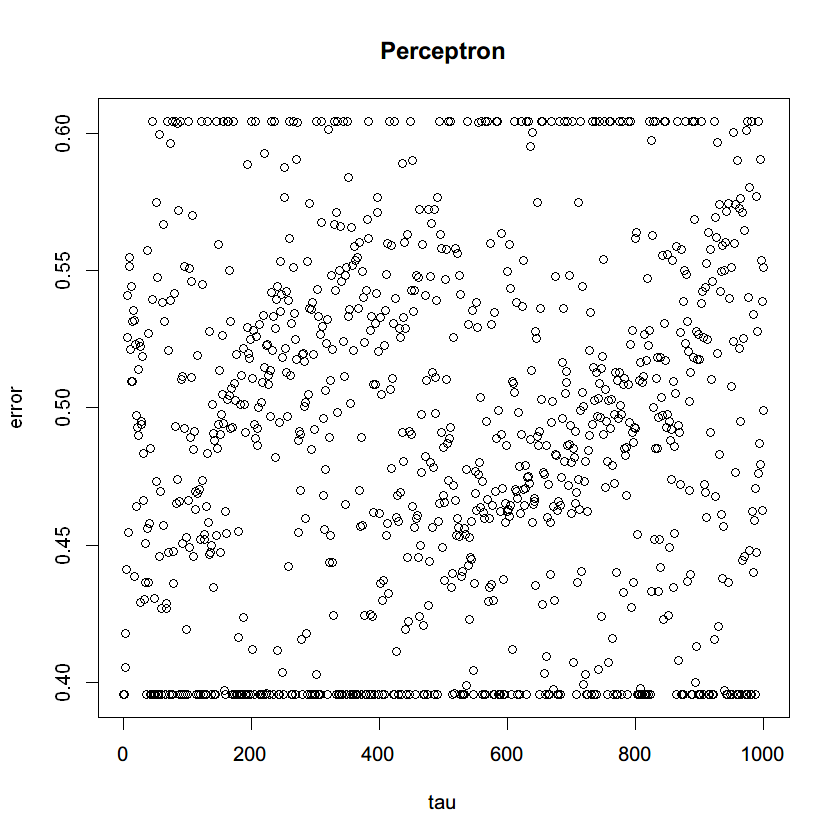

In [14]:
set.seed(0)
# perceptron model with learning rate = 0.09
W009 <- perceptron.build(X1, T1, tau.max = 1000, plotting = TRUE, eta = 0.09)

In [15]:
evaluate <- function(...) UseMethod("evaluate")

evaluate.perceptron <- function(W) {
    # return the test error of the perceptron model
    Phi <- cbind(1, X2) %>% data.matrix
    pred <- perceptron.predict(Phi, W)
    1 - sum(pred == T2) / length(T2)
}

print("The Test Error of Perceptron with Learning Rate = 0.01")
print(evaluate.perceptron(W001))

print("The Test Error of Perceptron with Learning Rate = 0.09")
print(evaluate.perceptron(W009))

[1] "The Test Error of Perceptron with Learning Rate = 0.01"
[1] 0.5252
[1] "The Test Error of Perceptron with Learning Rate = 0.09"
[1] 0.5484


After the implementation of perceptron with learning rate equaling to 0.01 and 0.09. The test error of these 2 models are also evaluated, and the perceptron with learning rate equaling 0.01 has lower error. Therefore, this model will be visualized below.

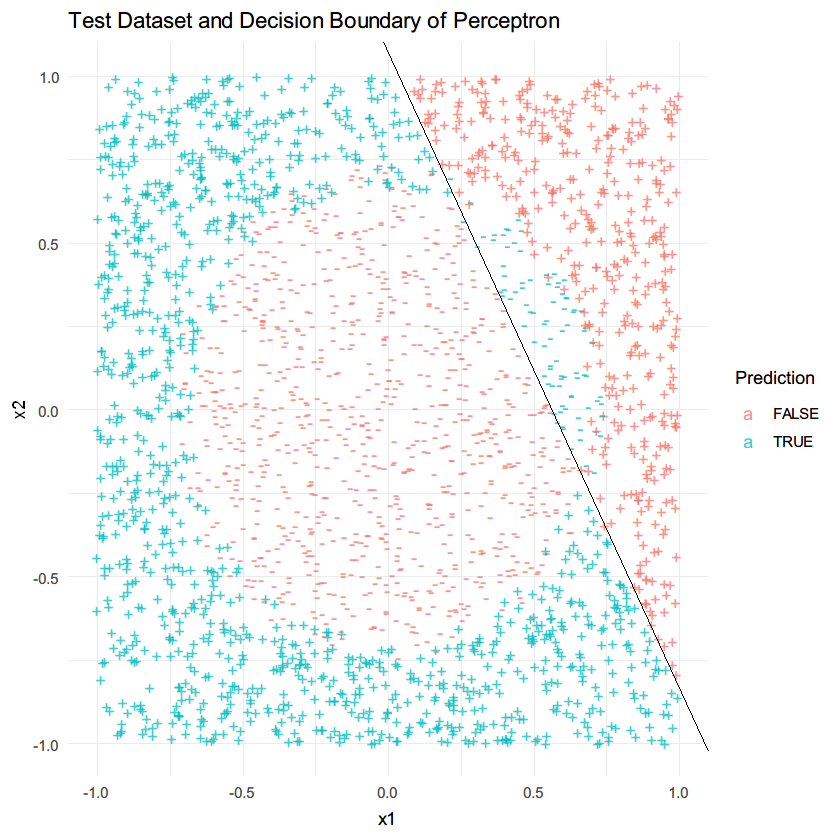

In [16]:
plot.test <- function(...) UseMethod("plot.test")

plot.test.perceptron <- function(W) {
    Phi <- cbind(1, X2) %>% data.matrix
    ggplot(data=as.data.frame(Phi), aes(x=x1, y=x2, label=ifelse(T2!=1, '-', '+'), color=factor(Phi%*%W*T2>0))) +
        geom_text(alpha=0.75) +
        scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
        geom_abline(intercept=-W[1]/W[3], slope=-W[2]/W[3]) +
        ggtitle('Test Dataset and Decision Boundary of Perceptron') +
        theme_minimal()
}

attr(W001, "class") <- "perceptron"
plot.test(W001)

From the output, the perceptron can only divide the data linearly, so it performs  bad in this dataset.

## 3-Layer Neural Network

Then, the 3-layer neural networks with specified K (the number of hidden neurons) and learning rate are built for comparison.  

In [17]:
X1.t <- t(as.matrix(X1))
X2.t <- t(as.matrix(X2))

evaluate.nn <- function(nn) {
    # return the test error of the NN model
    list[W1, W2, b1, b2] <- nn
    pred <- nn.predict(X2.t, W1, W2, b1, b2)
    1 - sum(pred == T2) / length(T2)
}

In [18]:
# A data frame to store the error
nn.errors <- data.frame(K = numeric(), eta = numeric(), error = numeric())
# A partial function for build a model
nn.build.k.eta <- function(k, eta) nn.build(k, X1.t, T1, plotting=FALSE, epoch.max=50, eta = eta, lambda = 0)

for (k in seq(5, 100, 5)) {
  for (eta in c(0.01, 0.09)) {
    set.seed(0)
    nn.model <- nn.build.k.eta(k, eta)
    #? Evaluate the model
    attr(nn.model, "class") <- "nn"
    error <- list(K = k, eta = eta, error = evaluate(nn.model))
    #? Record the test errors for plotting purposes
    nn.errors <- rbind(nn.errors, error)
  }
}

The visualization of test errors of 40 neural networks with specified hyperparameters are shown below.

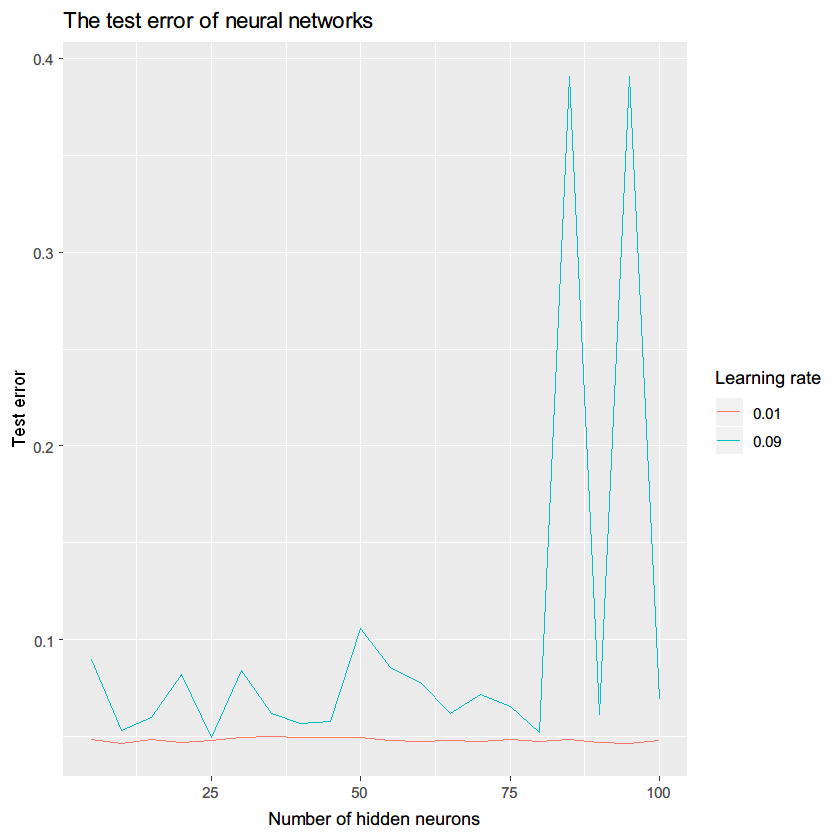

In [19]:
# Plot the test error versus number of units
nn.errors %>% ggplot + 
    geom_line(aes(x = K, y = error, color = as.factor(eta))) + 
    ggtitle("The test error of neural networks") + 
    labs(x="Number of hidden neurons", y = "Test error", color = "Learning rate")

From the output, the error with learning rate equaling to 0.01 are significantly lower than 0.09. That is because the model with lower learning rate can avoid the overshooting in gradient descent process, so the loss of them will be trained to local minima better.

### Find best nn model

In [17]:
list[k.best, eta.best] <- nn.errors[which.min(nn.errors$error),]
nn.model.best <- nn.build.k.eta(k.best, eta.best)
print(paste0("Best K: ", k.best, sep = ""))
print(paste0("Best learning rate: ", eta.best, sep = ""))

[1] "Best K: 10"
[1] "Best learning rate: 0.01"


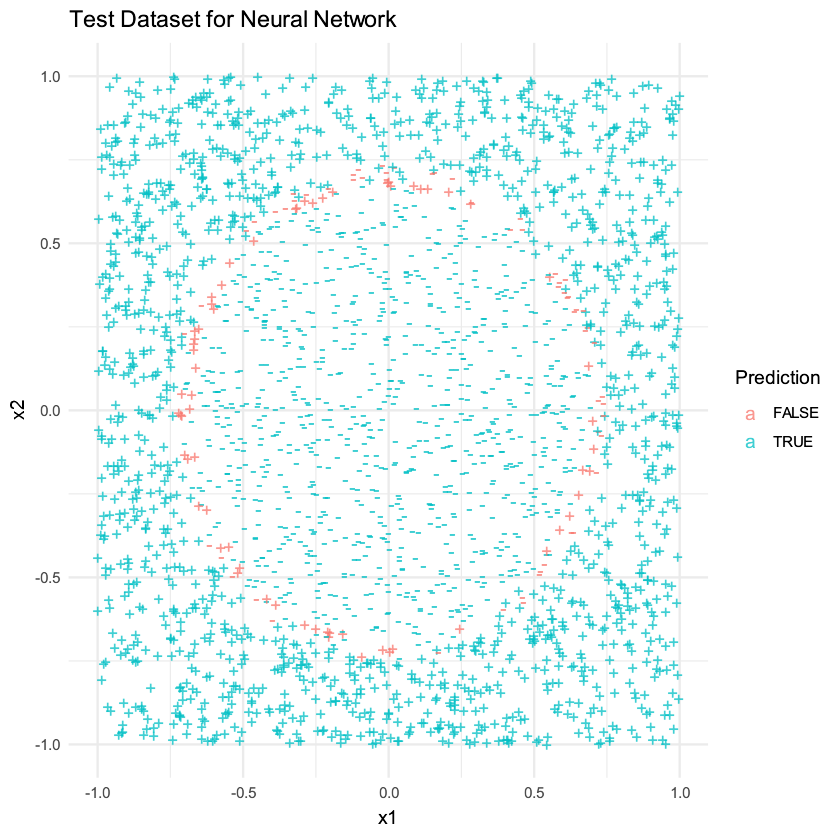

In [18]:
plot.test.nn <- function(nn) {
    # return the test error of the NN model
    list[W1, W2, b1, b2] <- nn
    pred <- nn.predict(X2.t, W1, W2, b1, b2)

    ggplot(data=X2, aes(x=x1, y=x2, label=ifelse(T2!=1, '-', '+'), color=factor(pred * T2 > 0))) +
        geom_text(alpha=0.75) +
        scale_color_discrete(guide = guide_legend(title = 'Prediction')) +
        ggtitle('Test Dataset for Neural Network') +
        theme_minimal()
}

plot.test.nn(nn.model.best)

## Explain

From 2 figures about test data result, the results are totally different. The main reason causing this situation is that the perceptron can only handle the linearly separable data because the perceptron is linear model. However, with non-linear activation function applied to neural network, the neural network can perform non-linearly which is more suitable for this dataset.